# Assignment 3
Nathan Jester

## Part 1: Data Loading, Exploration, and Cleaning

### 1.1 Data Loading

Our goals is to build a mdoel for both prediction and explaination so we'll start with 2 dataframes, predict_df and explain_df.

In [172]:
from pathlib import Path

import pandas as pd


data_path = Path("heart_disease_uci-1.csv")
predict_df = pd.read_csv(data_path, index_col='id')
explain_df = pd.read_csv(data_path, index_col='id')
explain_df.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
id,,,,,,,,,,,,,,,
1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


### 1.2 Data Exploration anc Cleaning

#### 1.2.1 Handle Missing Values

For now the two dataframes are the same so lets look at missingness in explain_df.

In [173]:
missing_df = pd.DataFrame()
num_rows = explain_df.shape[0]
missing_count = explain_df.isna().sum()
missing_df["Missing Count"] = missing_count
missing_df["Missing %"] = round((missing_count / num_rows) * 100, 2)
missing_df.sort_values('Missing Count', inplace=True, ascending=False)
missing_df


,Missing Count,Missing %
ca,611,66.41
thal,486,52.83
slope,309,33.59
fbs,90,9.78
oldpeak,62,6.74
trestbps,59,6.41
thalch,55,5.98
exang,55,5.98
chol,30,3.26
restecg,2,0.22


Explainatory modeling requires understanding of missingness of values and handling of them apropriately.  Handling missing values apropriatly commonly requires domain knowledge and in this case I have none, so I will drop the colums that are missing lots of data.  

Predictive modeling is less picky about missingness and is able to pick up effects between variables that weren't oribinally being looked for.  As a result, any data cleaning that improves the prediction is valid.  

For simplicity, I'll drop ca, thal, and slope, then handle missing values ona per dataframe basis.

In [174]:
cols_to_drop = ["ca", "thal", "slope"]
explain_df.drop(columns=cols_to_drop, inplace=True)
predict_df.drop(columns=cols_to_drop, inplace=True)

Next lets handle the missing values.

For predict_df we'll impute valeus for missing data.  For now, imputed values will simple be the mean, for simplicity.

In [175]:
# get fill values
numeric_cols = predict_df.select_dtypes([int, float]).columns
numeric_col_means = predict_df[numeric_cols].mean()
print("Numeric Column Means")
print(numeric_col_means)

# apply fill values
fill_val_map = {col: mean for col, mean in numeric_col_means.items()}
predict_df.fillna(fill_val_map, inplace=True)

# show results
print("\nNumeric Column Missing Counts")
print(predict_df[numeric_cols].isna().sum())

Numeric Column Means
age          53.510870
trestbps    132.132404
chol        199.130337
thalch      137.545665
oldpeak       0.878788
num           0.995652
dtype: float64

Numeric Column Missing Counts
age         0
trestbps    0
chol        0
thalch      0
oldpeak     0
num         0
dtype: int64


For explain_df, we'll drop rows with missing data.

In [176]:
print("Row count before dropping missing values", explain_df.shape[0])
explain_df.dropna(inplace=True)
print("Row count after dropping missing values", explain_df.shape[0])

Row count before dropping missing values 920
Row count after dropping missing values 740


#### 1.2.2 Handle Catagorical Variables

Next, lets identify catagorical variables and split them into dummy variables.

In [177]:
print(predict_df.dtypes)
predict_df.head()

age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
num           int64
dtype: object


,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,num
id,,,,,,,,,,,,
1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,0
2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,2
3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,1
4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,0
5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,0


In [178]:
catagorical_columns=["sex", "dataset", "cp", "fbs", "restecg", "exang"]

Before cleaning, lets look at the distribtuion of catagorical variables.

Following are the explainatory distributions.

{'sex': 2, 'dataset': 4, 'cp': 4, 'fbs': 2, 'restecg': 3, 'exang': 2}


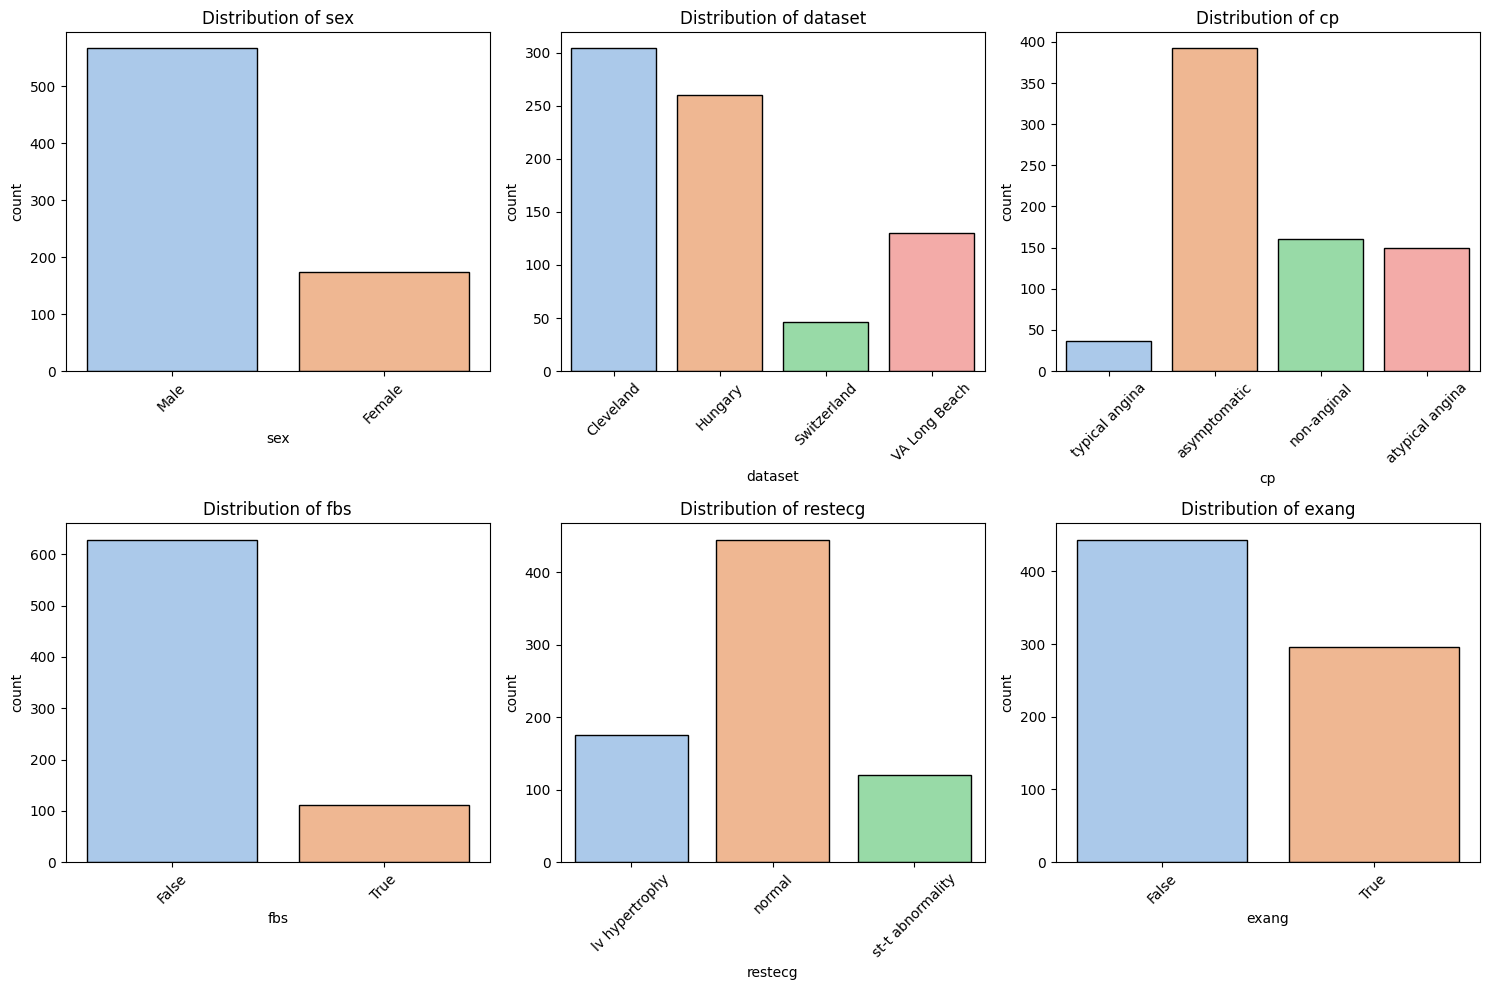

In [182]:
from matplotlib import pyplot as plt
import seaborn as sns


unique_counts = {col: explain_df[col].nunique() for col in catagorical_columns}
print(unique_counts)

plt.figure(figsize=(15, 10))
for i, col in enumerate(catagorical_columns, 1):
    plt.subplot(2, 3, i)  # Adjust layout for better visualization
    sns.countplot(data=explain_df, x=col, hue=col, palette="pastel", edgecolor="black", legend=False)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Following are the predict_df distributions.

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns


unique_counts = {col: explain_df[col].nunique() for col in catagorical_columns}
print(unique_counts)

plt.figure(figsize=(15, 10))
for i, col in enumerate(catagorical_columns, 1):
    plt.subplot(2, 3, i)  # Adjust layout for better visualization
    sns.countplot(data=predict_df, x=col, hue=col, palette="pastel", edgecolor="black", legend=False)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

For explain_df, we'll leave all the catagorical variables in.  This introduces the chance of multicolinearitiy, but also allows us to extract statistics for each varible, such as their p value.

In [ ]:
explain_df = pd.get_dummies(explain_df, columns=catagorical_columns, dtype=int)
explain_df.columns = [c.replace(' ', '_').lower() for c in explain_df.columns]
print(explain_df.dtypes)
explain_df.head()

age                           int64
trestbps                    float64
chol                        float64
thalch                      float64
oldpeak                     float64
num                           int64
sex_female                    int64
sex_male                      int64
dataset_cleveland             int64
dataset_hungary               int64
dataset_switzerland           int64
dataset_va_long_beach         int64
cp_asymptomatic               int64
cp_atypical_angina            int64
cp_non-anginal                int64
cp_typical_angina             int64
fbs_false                     int64
fbs_true                      int64
restecg_lv_hypertrophy        int64
restecg_normal                int64
restecg_st-t_abnormality      int64
exang_false                   int64
exang_true                    int64
dtype: object


,age,trestbps,chol,thalch,oldpeak,num,sex_female,sex_male,dataset_cleveland,dataset_hungary,...,cp_atypical_angina,cp_non-anginal,cp_typical_angina,fbs_false,fbs_true,restecg_lv_hypertrophy,restecg_normal,restecg_st-t_abnormality,exang_false,exang_true
id,,,,,,,,,,,,,,,,,,,,,
1,63,145.0,233.0,150.0,2.3,0,0,1,1,0,...,0,0,1,0,1,1,0,0,1,0
2,67,160.0,286.0,108.0,1.5,2,0,1,1,0,...,0,0,0,1,0,1,0,0,0,1
3,67,120.0,229.0,129.0,2.6,1,0,1,1,0,...,0,0,0,1,0,1,0,0,0,1
4,37,130.0,250.0,187.0,3.5,0,0,1,1,0,...,0,1,0,1,0,0,1,0,1,0
5,41,130.0,204.0,172.0,1.4,0,1,0,1,0,...,1,0,0,1,0,1,0,0,1,0


For predict_df, we're not as concerned about explainability and prefer to drop variables to avoid multicolinearity and provide a better prediction.

In [ ]:
predict_df = pd.get_dummies(predict_df, columns=catagorical_columns, dtype=int, drop_first=True)
predict_df.columns = [c.replace(' ', '_').lower() for c in predict_df.columns]
print(predict_df.dtypes)
predict_df.head()

age                           int64
trestbps                    float64
chol                        float64
thalch                      float64
oldpeak                     float64
num                           int64
sex_male                      int64
dataset_hungary               int64
dataset_switzerland           int64
dataset_va_long_beach         int64
cp_atypical_angina            int64
cp_non-anginal                int64
cp_typical_angina             int64
fbs_true                      int64
restecg_normal                int64
restecg_st-t_abnormality      int64
exang_true                    int64
dtype: object


,age,trestbps,chol,thalch,oldpeak,num,sex_male,dataset_hungary,dataset_switzerland,dataset_va_long_beach,cp_atypical_angina,cp_non-anginal,cp_typical_angina,fbs_true,restecg_normal,restecg_st-t_abnormality,exang_true
id,,,,,,,,,,,,,,,,,
1,63,145.0,233.0,150.0,2.3,0,1,0,0,0,0,0,1,1,0,0,0
2,67,160.0,286.0,108.0,1.5,2,1,0,0,0,0,0,0,0,0,0,1
3,67,120.0,229.0,129.0,2.6,1,1,0,0,0,0,0,0,0,0,0,1
4,37,130.0,250.0,187.0,3.5,0,1,0,0,0,0,1,0,0,1,0,0
5,41,130.0,204.0,172.0,1.4,0,0,0,0,0,1,0,0,0,0,0,0


#### 1.2.3 Visualize the Clean Data

Lets view the explain_df numeric variable distributions.

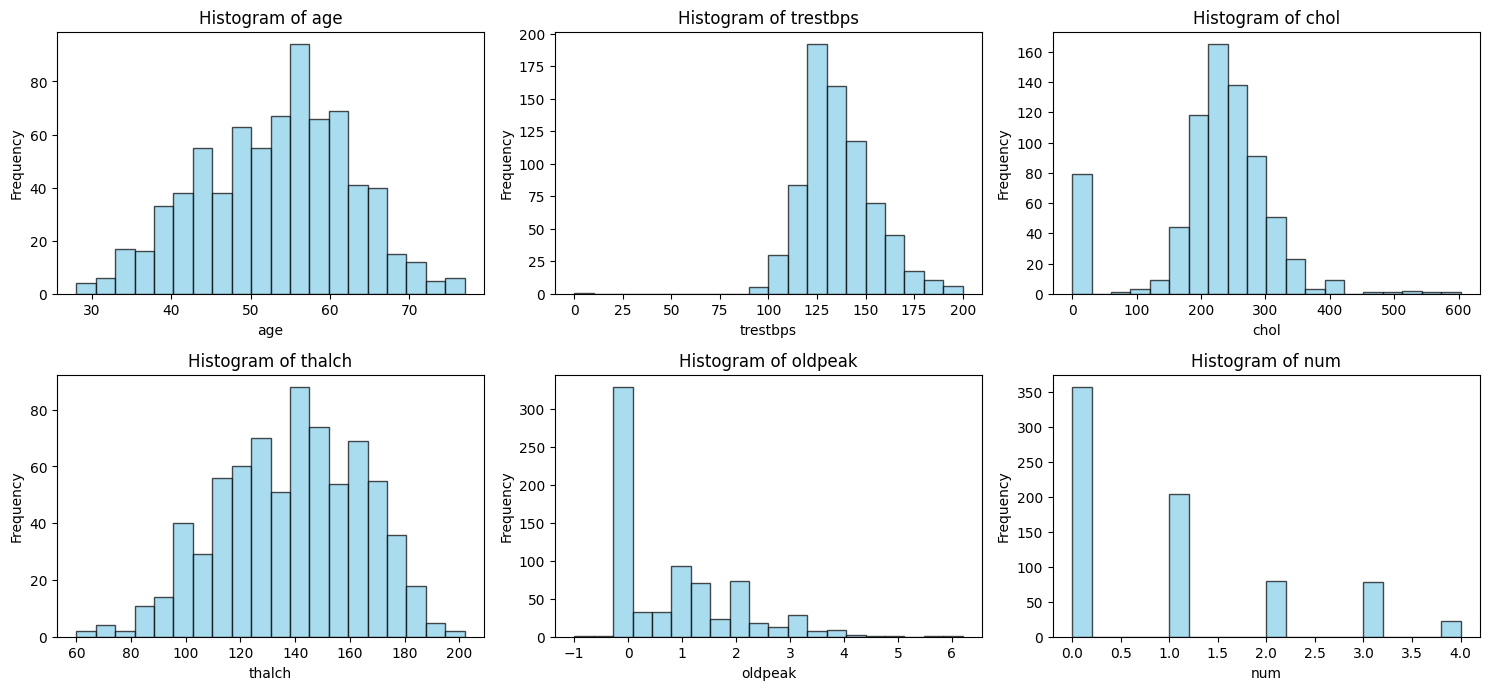

In [ ]:
# Generate histograms for numerical variables
from matplotlib import pyplot as plt


plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)  # Adjust layout for better visualization
    plt.hist(explain_df[col].dropna(), bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Next, lets view the distribution of the prediction variables.

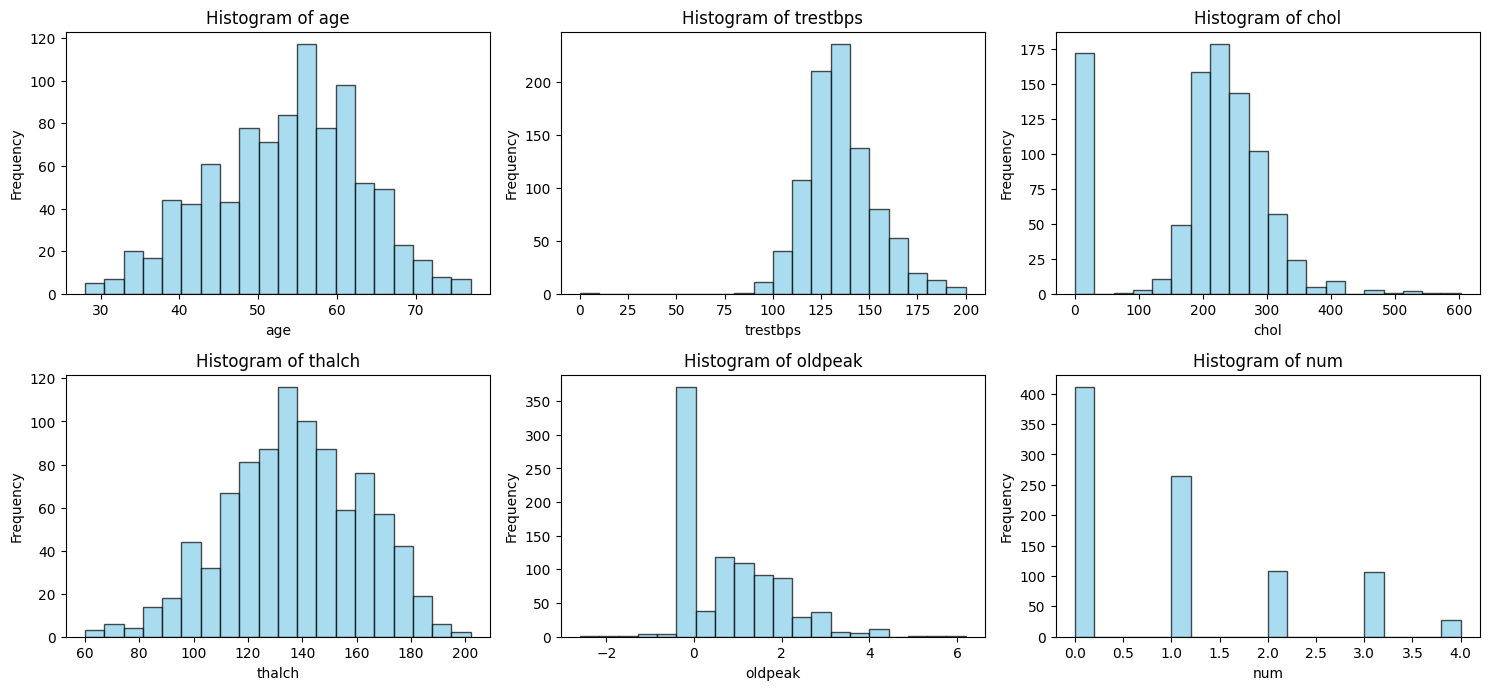

In [ ]:
# Generate histograms for numerical variables
from matplotlib import pyplot as plt


plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)  # Adjust layout for better visualization
    plt.hist(predict_df[col].dropna(), bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()